# Step 1: Stationarity and Seasonal Diagnostics for Net_demand

This notebook performs exploratory diagnostics only. It does **not** fit ARIMA/SARIMA/SARIMAX models, does not forecast, and does not use test data.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.style.use("seaborn-v0_8-whitegrid")

[Data] Rows: 3471
[Data] Date range: 2013-03-02 to 2022-09-01
[Data] Inferred frequency: D
[Data] All daily steps: True
[Net_demand] Min: 28134.625
[Net_demand] Max: 83312.4166666667
[Net_demand] Mean: 49112.174691491404
[Net_demand] Std: 10697.628158540543
[Net_demand] Describe:
 count     3471.000000
mean     49112.174691
std      10697.628159
min      28134.625000
25%      40884.979167
50%      46326.895833
75%      56610.281250
max      83312.416667
Name: Net_demand, dtype: float64


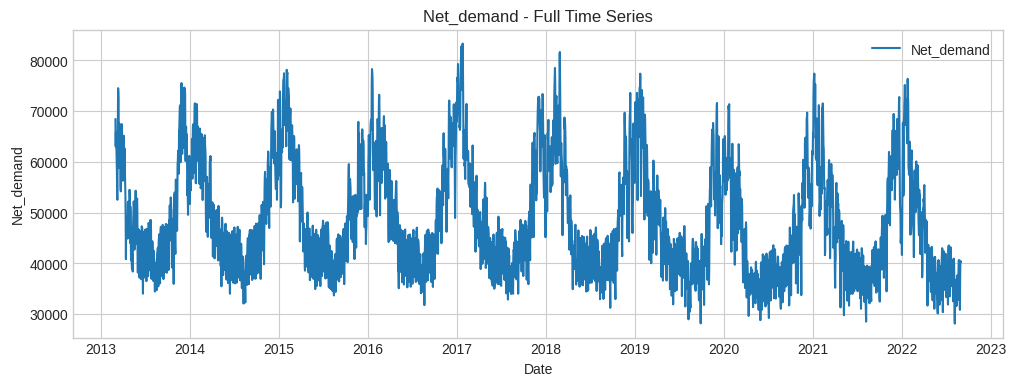

In [36]:
# 1. Load and prepare data
train_path = "../Data/train.csv"

train_df = pd.read_csv(train_path, parse_dates=["Date"])
train_df = train_df.sort_values("Date").reset_index(drop=True)

print("[Data] Rows:", len(train_df))
print("[Data] Date range:", train_df["Date"].min().date(), "to", train_df["Date"].max().date())

# Set DateTimeIndex
train_df = train_df.set_index("Date")
train_df.index = pd.DatetimeIndex(train_df.index)

# Verify frequency
inferred_freq = pd.infer_freq(train_df.index)
all_daily = (train_df.index.to_series().diff().dropna() == pd.Timedelta(days=1)).all()
print("[Data] Inferred frequency:", inferred_freq)
print("[Data] All daily steps:", all_daily)

# Summary statistics for Net_demand
y = train_df["Net_demand"]
print("[Net_demand] Min:", y.min())
print("[Net_demand] Max:", y.max())
print("[Net_demand] Mean:", y.mean())
print("[Net_demand] Std:", y.std())
print("[Net_demand] Describe:\n", y.describe())

# Plot full time series
plt.figure(figsize=(12, 4))
plt.plot(y, label="Net_demand")
plt.title("Net_demand - Full Time Series")
plt.xlabel("Date")
plt.ylabel("Net_demand")
plt.legend()
plt.show()

[Rolling] Mean drift (last - first): -25726.657738095222
[Rolling] Std drift (last - first): 407.19604131985807


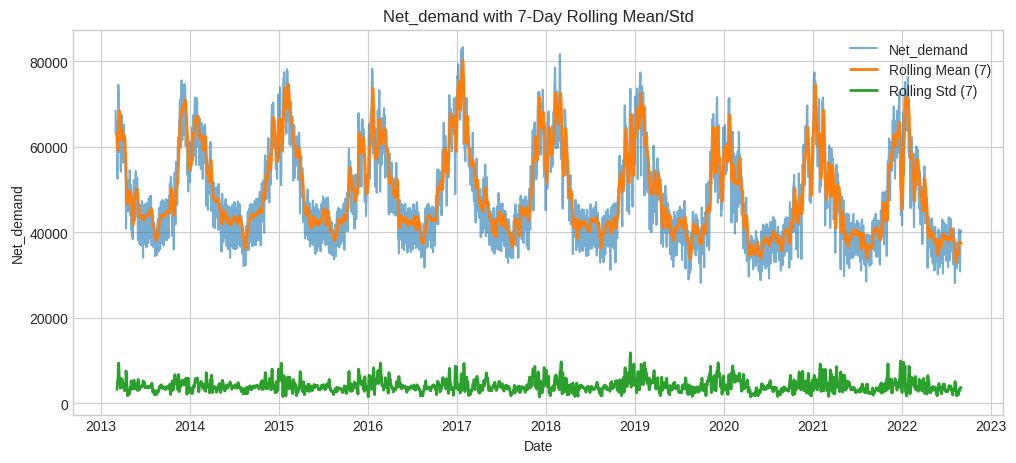

In [5]:
# 2. Visual stationarity inspection (rolling stats)
rolling_mean_7 = y.rolling(window=7).mean()
rolling_std_7 = y.rolling(window=7).std()

# Visual stationarity implies a roughly constant mean and variance over time.
# The plotted rolling mean/std and drift values below help interpret what we observe.
mean_drift = rolling_mean_7.dropna().iloc[-1] - rolling_mean_7.dropna().iloc[0]
std_drift = rolling_std_7.dropna().iloc[-1] - rolling_std_7.dropna().iloc[0]
print("[Rolling] Mean drift (last - first):", mean_drift)
print("[Rolling] Std drift (last - first):", std_drift)

plt.figure(figsize=(12, 5))
plt.plot(y, label="Net_demand", alpha=0.6)
plt.plot(rolling_mean_7, label="Rolling Mean (7)", linewidth=2)
plt.plot(rolling_std_7, label="Rolling Std (7)", linewidth=2)
plt.title("Net_demand with 7-Day Rolling Mean/Std")
plt.xlabel("Date")
plt.ylabel("Net_demand")
plt.legend()
plt.show()

In [ ]:
# 3. Formal stationarity tests (ADF and KPSS)

def run_adf(series, name):
    # ADF null hypothesis: series has a unit root (non-stationary).
    result = adfuller(series.dropna(), autolag="AIC")
    output = {
        "test": "ADF",
        "series": name,
        "stat": result[0],
        "pvalue": result[1],
        "lags": result[2],
        "nobs": result[3],
    }

    print(f"[ADF] {name} | stat={output['stat']:.4f} | p={output['pvalue']:.4f} | lags={output['lags']} | n={output['nobs']}")
    # If p < 0.05, reject unit root 
    # => evidence of stationarity.
    return output


def run_kpss(series, name):
    # KPSS null hypothesis: series is level stationary.
    result = kpss(series.dropna(), regression="c", nlags="auto")
    output = {
        "test": "KPSS",
        "series": name,
        "stat": result[0],
        "pvalue": result[1],
        "lags": result[2],
    }
    print(f"[KPSS] {name} | stat={output['stat']:.4f} | p={output['pvalue']:.4f} | lags={output['lags']}")
    # If p < 0.05, reject stationarity => evidence of non-stationarity.
    return output

print("\n[Tests] Original series")
adf_orig = run_adf(y, "Net_demand")
kpss_orig = run_kpss(y, "Net_demand")

adf_orig_stationary = adf_orig["pvalue"] < 0.05
kpss_orig_stationary = kpss_orig["pvalue"] > 0.05

if adf_orig_stationary != kpss_orig_stationary:
    # Explicitly state conflict when ADF and KPSS disagree.
    print("[Tests] Conflict detected: ADF and KPSS lead to different conclusions on stationarity.")


[Tests] Original series
[ADF] Net_demand | stat=-4.4304 | p=0.0003 | lags=30 | n=3440
[KPSS] Net_demand | stat=0.4749 | p=0.0473 | lags=36
[Tests] Conflict detected: ADF and KPSS lead to different conclusions on stationarity.


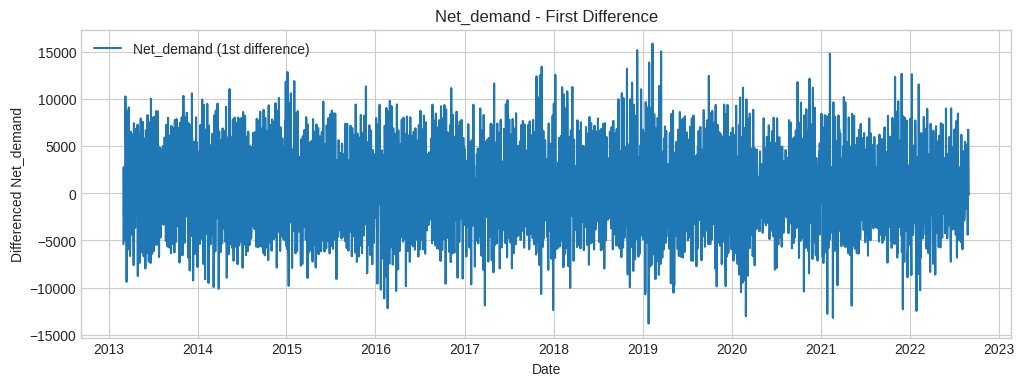


[Tests] First-differenced series
[ADF] Net_demand (diff 1) | stat=-11.8474 | p=0.0000 | lags=30 | n=3439
[KPSS] Net_demand (diff 1) | stat=0.0206 | p=0.1000 | lags=84


/tmp/ipykernel_33833/1376948708.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression="c", nlags="auto")


In [7]:
# 4. Differencing analysis (first difference)
y_diff = y.diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(y_diff, label="Net_demand (1st difference)")
plt.title("Net_demand - First Difference")
plt.xlabel("Date")
plt.ylabel("Differenced Net_demand")
plt.legend()
plt.show()

print("\n[Tests] First-differenced series")
adf_diff = run_adf(y_diff, "Net_demand (diff 1)")
kpss_diff = run_kpss(y_diff, "Net_demand (diff 1)")

adf_diff_stationary = adf_diff["pvalue"] < 0.05
kpss_diff_stationary = kpss_diff["pvalue"] > 0.05

if adf_diff_stationary != kpss_diff_stationary:
    print("[Tests] Conflict detected: ADF and KPSS disagree after differencing.")

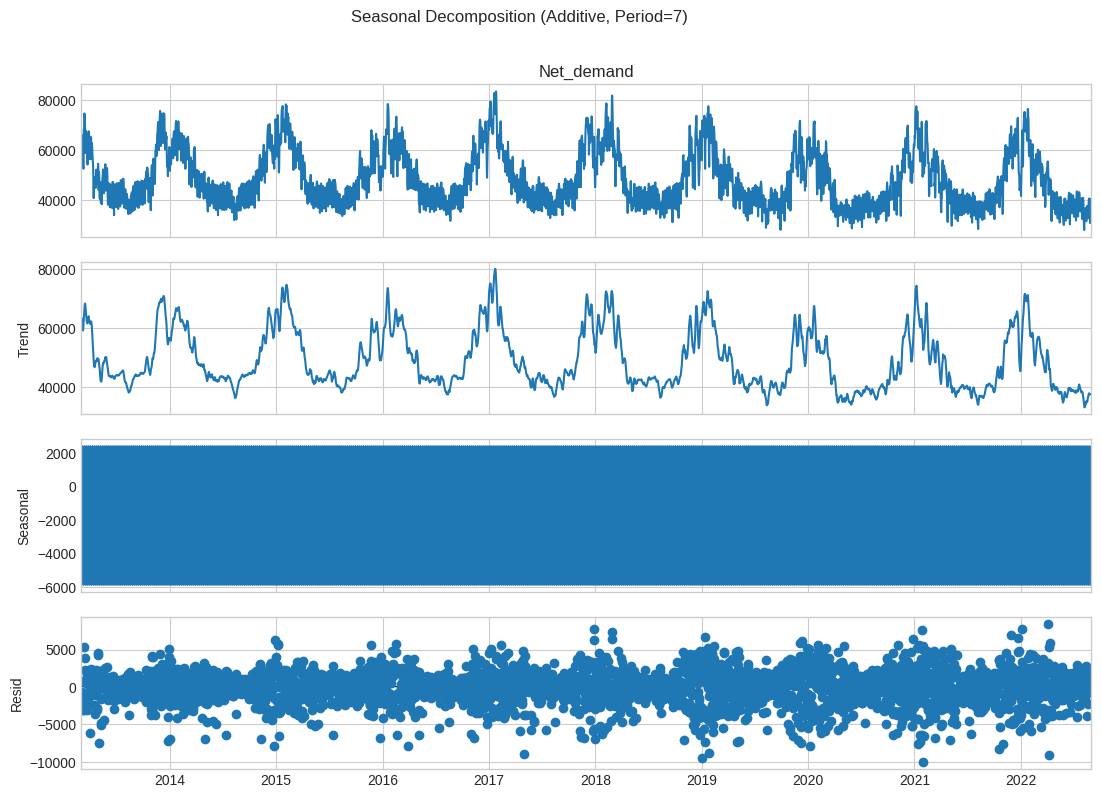

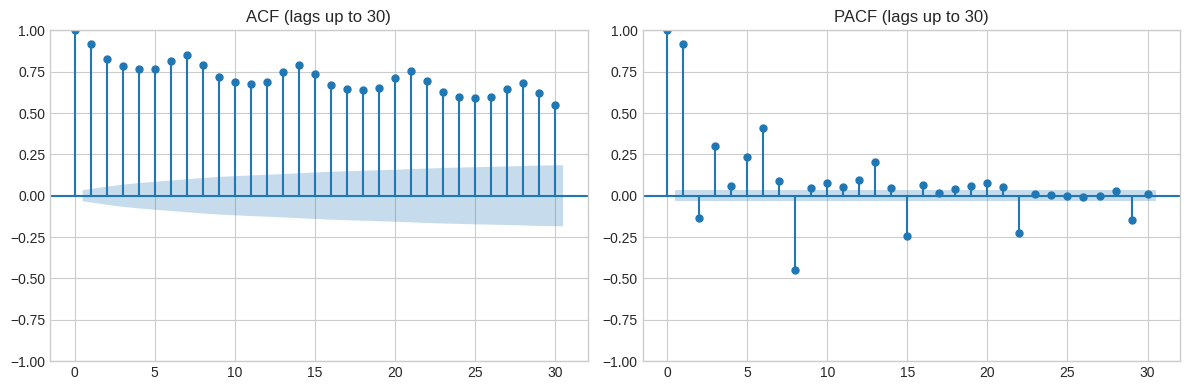

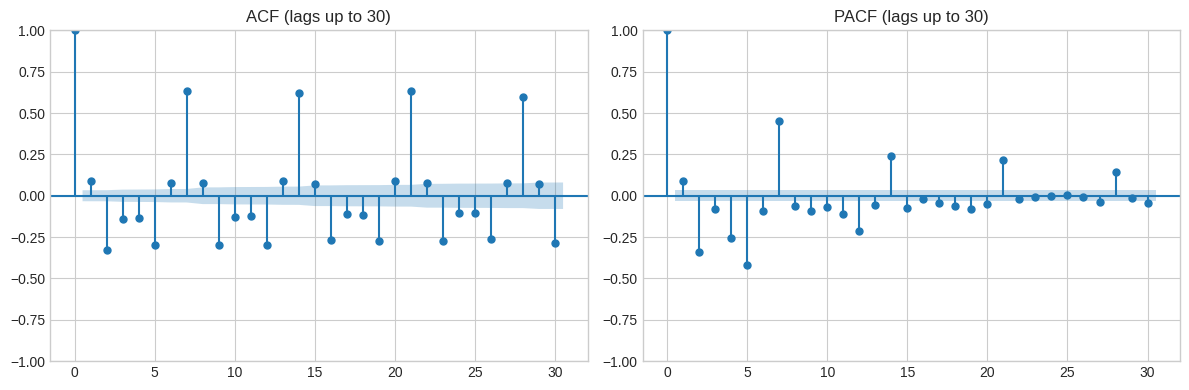

In [12]:
# 5. Seasonal diagnostics (weekly period = 7)
# Seasonal decomposition (additive)
y_daily = y.asfreq("D")

y_daily_clean = y_daily.dropna()

decomp = seasonal_decompose(y_daily_clean, model="additive", period=7)
fig = decomp.plot()
fig.set_size_inches(12, 8)
fig.suptitle("Seasonal Decomposition (Additive, Period=7)", y=1.02)
plt.show()

# ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y_daily_clean, lags=30, ax=axes[0])
plot_pacf(y_daily_clean, lags=30, ax=axes[1], method="ywm")
axes[0].set_title("ACF (lags up to 30)")
axes[1].set_title("PACF (lags up to 30)")
plt.tight_layout()
plt.show()
# Look for spikes at lags 7, 14, 21 and any slow decay patterns in ACF/PACF.

#5.bis same seasonal diagnostics but on the differenced series
y_diff_daily = y_diff.asfreq("D").dropna()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(y_diff_daily, lags=30, ax=axes[0])
plot_pacf(y_diff_daily, lags=30, ax=axes[1], method="ywm")
axes[0].set_title("ACF (lags up to 30)")
axes[1].set_title("PACF (lags up to 30)")
plt.tight_layout()
plt.show()


In [ ]:
# 6. Structured conclusion

def stationarity_label(adf_stationary, kpss_stationary):
    if adf_stationary and kpss_stationary:
        return "Stationary (both tests agree)"
    if (not adf_stationary) and (not kpss_stationary):
        return "Non-stationary (both tests agree)"
    return "Inconclusive (tests conflict)"

orig_label = stationarity_label(adf_orig_stationary, kpss_orig_stationary)
diff_label = stationarity_label(adf_diff_stationary, kpss_diff_stationary)

# Differencing recommendation (d) should be based on both visual inspection and tests.
if orig_label.startswith("Non-stationary") and diff_label.startswith("Stationary"):
    d_candidate = "1 (first difference likely helps)"
elif orig_label.startswith("Stationary"):
    d_candidate = "0 (no differencing suggested)"
else:
    d_candidate = "Undetermined (inspect plots and test conflicts)"

print("\n" + "=" * 60)
print("DIAGNOSTIC SUMMARY")
print("=" * 60)
print("Is the series stationary?", orig_label)
print("Is first differencing required?", "Likely" if "1" in d_candidate else "Possibly not" if "0" in d_candidate else "Unclear")
print("Is weekly seasonality visible?", "Inspect decomposition/ACF/PACF for lag-7 spikes")
print("Candidate value for d:", d_candidate)
print("Candidate seasonal period:", "7 (daily data, weekly pattern check)")
print("=" * 60)

# Note: This step is diagnostic only. Do not fit ARIMA/SARIMA models here.


DIAGNOSTIC SUMMARY
Is the series stationary? Inconclusive (tests conflict)
Is first differencing required? Unclear
Is weekly seasonality visible? Inspect decomposition/ACF/PACF for lag-7 spikes
Candidate value for d: Undetermined (inspect plots and test conflicts)
Candidate seasonal period: 7 (daily data, weekly pattern check)


# Step 2: ARIMA Baseline (Non-Seasonal)

This step fits an ARIMA(p,1,q) model with d=1 (fixed from Step 1 diagnostics).
The model is intentionally misspecified to quantify residual structure before introducing seasonal terms.
No SARIMA, no forecasting, no test set usage.

In [14]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import warnings

warnings.filterwarnings("ignore")

# 1. Data preparation (reconfirm state from Step 1)
print("[Step2] Data already loaded from Step 1:")
print(f"[Step2] y shape: {y.shape}")
print(f"[Step2] y index frequency: {y.index.inferred_freq}")
print(f"[Step2] y missing values: {y.isna().sum()}")
print(f"[Step2] y min/max: {y.min():.2f} / {y.max():.2f}")

# Verify no missing values for ARIMA
assert y.isna().sum() == 0, "Series contains missing values; cannot fit ARIMA."
print("[Step2] ✓ Data validation passed.\n")

[Step2] Data already loaded from Step 1:
[Step2] y shape: (3471,)
[Step2] y index frequency: D
[Step2] y missing values: 0
[Step2] y min/max: 28134.62 / 83312.42
[Step2] ✓ Data validation passed.



In [15]:
# 2. Grid search: ARIMA(p,1,q) for p,q in {0,1,2,3}
# d=1 is fixed from Step 1 diagnostics.

p_range = [0, 1, 2, 3]
q_range = [0, 1, 2, 3]
d_fixed = 1

grid_results = []

print("[GridSearch] Starting ARIMA grid search (d=1 fixed)...")
print("[GridSearch] Grid size: {} models\n".format(len(p_range) * len(q_range)))

for p in p_range:
    for q in q_range:
        try:
            # Fit ARIMA model using statespace method
            model = ARIMA(y, order=(p, d_fixed, q))
            results = model.fit(method_kwargs={"disp": False})
            
            grid_results.append({
                "p": p,
                "d": d_fixed,
                "q": q,
                "AIC": results.aic,
                "BIC": results.bic,
                "converged": results.mle_retvals["converged"] if hasattr(results.mle_retvals, "__getitem__") else True,
                "model": results
            })
            status = "✓" if grid_results[-1]["converged"] else "⚠"
            print(f"[GridSearch] {status} ARIMA({p},{d_fixed},{q}): AIC={results.aic:.2f}, BIC={results.bic:.2f}")
        except Exception as e:
            print(f"[GridSearch] ✗ ARIMA({p},{d_fixed},{q}): {str(e)[:60]}")

# Convert to DataFrame and sort by AIC
results_df = pd.DataFrame([
    {k: v for k, v in row.items() if k != "model"}
    for row in grid_results
])
results_df = results_df.sort_values("AIC").reset_index(drop=True)

print("\n[GridSearch] Top 5 models by AIC:")
print(results_df.head(5).to_string())
print()

[GridSearch] Starting ARIMA grid search (d=1 fixed)...
[GridSearch] Grid size: 16 models

[GridSearch] ✓ ARIMA(0,1,0): AIC=67853.44, BIC=67859.59
[GridSearch] ✓ ARIMA(0,1,1): AIC=67797.63, BIC=67809.93
[GridSearch] ✓ ARIMA(0,1,2): AIC=67237.35, BIC=67255.81
[GridSearch] ✓ ARIMA(0,1,3): AIC=67148.84, BIC=67173.45
[GridSearch] ✓ ARIMA(1,1,0): AIC=67831.76, BIC=67844.06
[GridSearch] ✓ ARIMA(1,1,1): AIC=67668.09, BIC=67686.55
[GridSearch] ✓ ARIMA(1,1,2): AIC=67158.60, BIC=67183.21
[GridSearch] ✓ ARIMA(1,1,3): AIC=67141.05, BIC=67171.81
[GridSearch] ✓ ARIMA(2,1,0): AIC=67442.01, BIC=67460.46
[GridSearch] ✓ ARIMA(2,1,1): AIC=67136.04, BIC=67160.64
[GridSearch] ⚠ ARIMA(2,1,2): AIC=66709.80, BIC=66740.56
[GridSearch] ⚠ ARIMA(2,1,3): AIC=66563.72, BIC=66600.64
[GridSearch] ✓ ARIMA(3,1,0): AIC=67419.86, BIC=67444.46
[GridSearch] ✓ ARIMA(3,1,1): AIC=67135.85, BIC=67166.61
[GridSearch] ✓ ARIMA(3,1,2): AIC=67146.24, BIC=67183.15
[GridSearch] ⚠ ARIMA(3,1,3): AIC=66483.11, BIC=66526.17

[GridSearch] 

In [16]:
# 3. Fit best model (lowest AIC)
best_row = results_df.iloc[0]
best_p, best_d, best_q = int(best_row["p"]), d_fixed, int(best_row["q"])

print(f"[BestModel] Selected order: ARIMA({best_p},{best_d},{best_q})")
print(f"[BestModel] AIC: {best_row['AIC']:.2f}")
print(f"[BestModel] BIC: {best_row['BIC']:.2f}\n")

# Refit best model cleanly
best_model = ARIMA(y, order=(best_p, best_d, best_q))
best_results = best_model.fit()

print("=" * 70)
print(f"ARIMA({best_p},{best_d},{best_q}) MODEL SUMMARY")
print("=" * 70)
print(best_results.summary())
print("=" * 70)

[BestModel] Selected order: ARIMA(3,1,3)
[BestModel] AIC: 66483.11
[BestModel] BIC: 66526.17

ARIMA(3,1,3) MODEL SUMMARY
                               SARIMAX Results                                
Dep. Variable:             Net_demand   No. Observations:                 3471
Model:                 ARIMA(3, 1, 3)   Log Likelihood              -33234.555
Date:                Tue, 17 Feb 2026   AIC                          66483.110
Time:                        12:56:12   BIC                          66526.173
Sample:                    03-02-2013   HQIC                         66498.485
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8530      0.029     63.250      0.000       1.796       1.910
ar.L2     

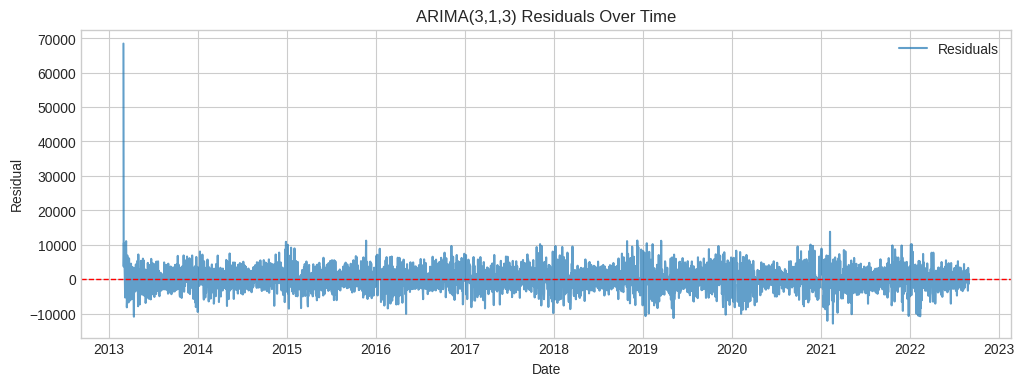

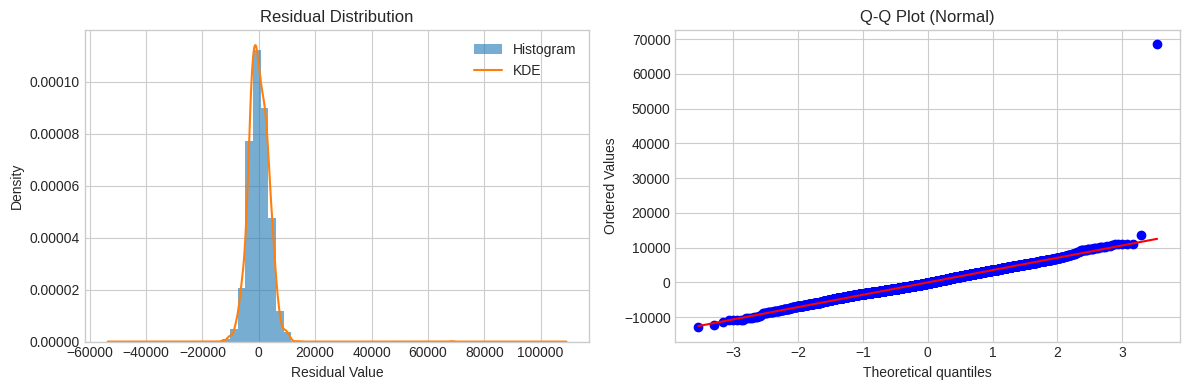

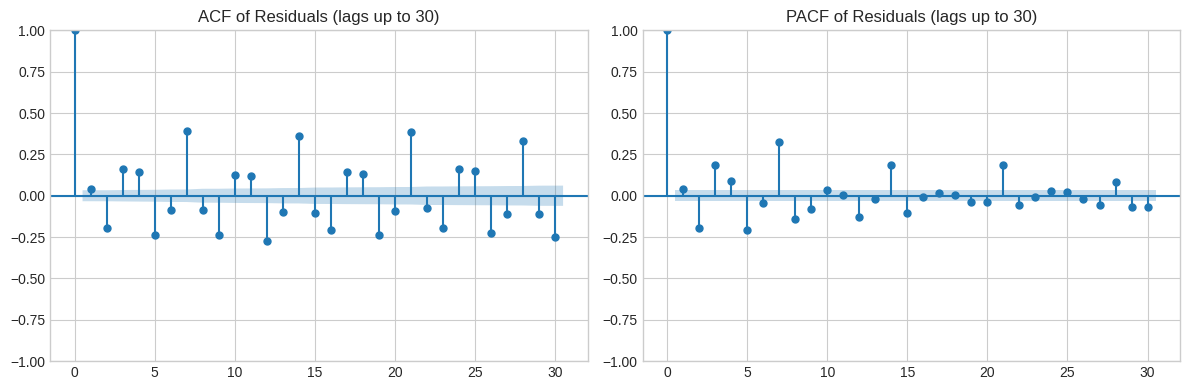


[Residuals] Distribution statistics:
  Mean: 15.821947
  Std: 3668.280851
  Min: -12924.57
  Max: 68453.00


In [17]:
# 4. Residual diagnostics

residuals = best_results.resid

# 4.1 Residual time series plot
plt.figure(figsize=(12, 4))
plt.plot(residuals, label="Residuals", alpha=0.7)
plt.axhline(y=0, color="r", linestyle="--", linewidth=1)
plt.title(f"ARIMA({best_p},{best_d},{best_q}) Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

# 4.2 Residual distribution (histogram + KDE)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram with KDE
axes[0].hist(residuals, bins=30, density=True, alpha=0.6, label="Histogram")
residuals.plot(kind="kde", ax=axes[0], label="KDE")
axes[0].set_title("Residual Distribution")
axes[0].set_xlabel("Residual Value")
axes[0].legend()

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot (Normal)")

plt.tight_layout()
plt.show()

# 4.3 ACF of residuals
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, lags=30, ax=axes[0])
plot_pacf(residuals, lags=30, ax=axes[1], method="ywm")
axes[0].set_title("ACF of Residuals (lags up to 30)")
axes[1].set_title("PACF of Residuals (lags up to 30)")
plt.tight_layout()
plt.show()

print("\n[Residuals] Distribution statistics:")
print(f"  Mean: {residuals.mean():.6f}")
print(f"  Std: {residuals.std():.6f}")
print(f"  Min: {residuals.min():.2f}")
print(f"  Max: {residuals.max():.2f}")

In [18]:
# 4.4 Ljung-Box test for autocorrelation (independence test)
# Null hypothesis: residuals are independent (no autocorrelation).
# If p < 0.05, reject independence => evidence of remaining autocorrelation.

lb_14 = acorr_ljungbox(residuals, lags=14, return_df=True)
lb_21 = acorr_ljungbox(residuals, lags=21, return_df=True)

print("\n[LjungBox] Lag-14 test:")
print(lb_14.to_string())

print("\n[LjungBox] Lag-21 test:")
print(lb_21.to_string())

# Extract p-values at specific lags (14 and 21)
lb_14_pval = lb_14.iloc[-1]["lb_pvalue"]  # Last row is lag 14
lb_21_pval = lb_21.iloc[-1]["lb_pvalue"]  # Last row is lag 21

print(f"\n[LjungBox] p-value at lag 14: {lb_14_pval:.4f}")
print(f"[LjungBox] p-value at lag 21: {lb_21_pval:.4f}")

# Interpretation
lb_14_reject = lb_14_pval < 0.05
lb_21_reject = lb_21_pval < 0.05

if lb_14_reject or lb_21_reject:
    print("[LjungBox] ⚠ Ljung-Box test rejects independence (p < 0.05).")
    print("[LjungBox] → Residuals show significant autocorrelation.")
else:
    print("[LjungBox] ✓ Ljung-Box test fails to reject independence (p > 0.05).")
    print("[LjungBox] → Residuals are approximately white noise.")


[LjungBox] Lag-14 test:
        lb_stat      lb_pvalue
1      5.694093   1.702210e-02
2    135.599680   3.588423e-30
3    226.350173   8.509835e-49
4    299.436054   1.433680e-63
5    498.940223  1.352096e-105
6    526.180912  1.921977e-110
7   1053.089927  4.059787e-223
8   1079.129334  1.231512e-227
9   1272.300584  2.969242e-268
10  1327.905201  3.630837e-279
11  1378.880279  4.336801e-289
12  1640.879369   0.000000e+00
13  1673.309664   0.000000e+00
14  2124.595344   0.000000e+00

[LjungBox] Lag-21 test:
        lb_stat      lb_pvalue
1      5.694093   1.702210e-02
2    135.599680   3.588423e-30
3    226.350173   8.509835e-49
4    299.436054   1.433680e-63
5    498.940223  1.352096e-105
6    526.180912  1.921977e-110
7   1053.089927  4.059787e-223
8   1079.129334  1.231512e-227
9   1272.300584  2.969242e-268
10  1327.905201  3.630837e-279
11  1378.880279  4.336801e-289
12  1640.879369   0.000000e+00
13  1673.309664   0.000000e+00
14  2124.595344   0.000000e+00
15  2161.931996   0.

In [19]:
# 4.5 Check for seasonal autocorrelation (at lag 7)
# Look for significant spikes in residual ACF at multiples of 7.

# Extract ACF correlations manually to check lag 7
from statsmodels.graphics.tsaplots import acf as acf_func

acf_vals = acf_func(residuals, nlags=30)
lag_7_acf = acf_vals[7]
lag_14_acf = acf_vals[14]
lag_21_acf = acf_vals[21]

# Rough 95% CI for ACF: ±1.96/sqrt(n)
n = len(residuals)
ci_upper = 1.96 / np.sqrt(n)
ci_lower = -1.96 / np.sqrt(n)

print(f"\n[Seasonality] Residual ACF at seasonal lags:")
print(f"  Lag 7 ACF: {lag_7_acf:.4f} (95% CI: [{ci_lower:.4f}, {ci_upper:.4f}])")
print(f"  Lag 14 ACF: {lag_14_acf:.4f}")
print(f"  Lag 21 ACF: {lag_21_acf:.4f}")

# Check if any lag-7 multiple exceeds confidence interval
lag_7_outside_ci = abs(lag_7_acf) > ci_upper
lag_14_outside_ci = abs(lag_14_acf) > ci_upper
lag_21_outside_ci = abs(lag_21_acf) > ci_upper

if lag_7_outside_ci or lag_14_outside_ci or lag_21_outside_ci:
    print("[Seasonality] ⚠ Strong autocorrelation detected at seasonal lags (multiples of 7).")
    print("[Seasonality] → This indicates missing seasonal structure (expected for non-seasonal ARIMA).")
else:
    print("[Seasonality] ✓ No strong autocorrelation at seasonal lags.")


[Seasonality] Residual ACF at seasonal lags:
  Lag 7 ACF: 0.3891 (95% CI: [-0.0333, 0.0333])
  Lag 14 ACF: 0.3597
  Lag 21 ACF: 0.3859
[Seasonality] ⚠ Strong autocorrelation detected at seasonal lags (multiples of 7).
[Seasonality] → This indicates missing seasonal structure (expected for non-seasonal ARIMA).


In [20]:
# 5. Structured conclusion block

# Determine if residuals are approximately white noise
residuals_white_noise = (not lb_14_reject) and (not lb_21_reject)

# Determine if seasonal autocorrelation is present
seasonal_autocorr_present = lag_7_outside_ci or lag_14_outside_ci or lag_21_outside_ci

# Overall model adequacy: white noise residuals without strong seasonal structure
model_adequate = residuals_white_noise and not seasonal_autocorr_present

print("\n" + "=" * 60)
print("ARIMA BASELINE SUMMARY")
print("=" * 60)
print(f"Selected order (p,1,q): ({best_p},{best_d},{best_q})")
print(f"AIC: {best_row['AIC']:.2f}")
print(f"BIC: {best_row['BIC']:.2f}")
print(f"\nResiduals approximately white noise? {'Yes' if residuals_white_noise else 'No'}")
print(f"  → Ljung-Box lag-14 p-value: {lb_14_pval:.4f}")
print(f"  → Ljung-Box lag-21 p-value: {lb_21_pval:.4f}")
print(f"\nEvidence of seasonal autocorrelation remaining? {'Yes' if seasonal_autocorr_present else 'No'}")
print(f"  → Lag-7 ACF: {lag_7_acf:.4f} (outside {ci_upper:.4f} CI: {lag_7_outside_ci})")
print(f"  → Lag-14 ACF: {lag_14_acf:.4f} (outside {ci_upper:.4f} CI: {lag_14_outside_ci})")
print(f"  → Lag-21 ACF: {lag_21_acf:.4f} (outside {ci_upper:.4f} CI: {lag_21_outside_ci})")
print(f"\nIs model adequate? {'Yes' if model_adequate else 'No (consider SARIMA)'}")
print("=" * 60)

# Diagnostic interpretation
if seasonal_autocorr_present:
    print("\n[Interpretation] This non-seasonal ARIMA baseline reveals significant")
    print("residual structure at seasonal lags (multiples of 7). SARIMA is recommended.")
else:
    print("\n[Interpretation] Residuals show minimal autocorrelation; non-seasonal ARIMA")
    print("may be sufficient, but proceed cautiously given known weekly seasonality.")


ARIMA BASELINE SUMMARY
Selected order (p,1,q): (3,1,3)
AIC: 66483.11
BIC: 66526.17

Residuals approximately white noise? No
  → Ljung-Box lag-14 p-value: 0.0000
  → Ljung-Box lag-21 p-value: 0.0000

Evidence of seasonal autocorrelation remaining? Yes
  → Lag-7 ACF: 0.3891 (outside 0.0333 CI: True)
  → Lag-14 ACF: 0.3597 (outside 0.0333 CI: True)
  → Lag-21 ACF: 0.3859 (outside 0.0333 CI: True)

Is model adequate? No (consider SARIMA)

[Interpretation] This non-seasonal ARIMA baseline reveals significant
residual structure at seasonal lags (multiples of 7). SARIMA is recommended.


# Step 3: SARIMA Model (With Weekly Seasonality)

This step fits SARIMA(p,1,q)×(P,D,Q,7) models.
We fix d=1 and s=7 from Step 1. We test both D=0 and D=1 to determine if seasonal differencing is needed.
Only converged models are ranked by AIC.

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 1. Data validation
print("[Step3] Data already loaded from Step 1:")
print(f"[Step3] y shape: {y.shape}")
print(f"[Step3] y index frequency: {y.index.inferred_freq}")
print(f"[Step3] y missing values: {y.isna().sum()}")
print(f"[Step3] y min/max: {y.min():.2f} / {y.max():.2f}")

# Confirm no missing values for SARIMA
assert y.isna().sum() == 0, "Series contains missing values; cannot fit SARIMA."
print("[Step3] ✓ Data validation passed.\n")

# Fixed parameters
d_fixed = 1
s_fixed = 7
print(f"[Step3] Fixed parameters: d={d_fixed}, s={s_fixed}\n")

[Step3] Data already loaded from Step 1:
[Step3] y shape: (3471,)
[Step3] y index frequency: D
[Step3] y missing values: 0
[Step3] y min/max: 28134.62 / 83312.42
[Step3] ✓ Data validation passed.

[Step3] Fixed parameters: d=1, s=7



In [29]:
# 2. Grid search: SARIMA(p,1,q)×(P,D,Q,7)
# p,q ∈ {0,1,2}, P,Q ∈ {0,1}, D ∈ {0,1}

p_range = [0, 1, 2]
q_range = [0, 1, 2]
P_range = [0, 1]
Q_range = [0]
D_range = [1]

grid_results_s3 = []
total_models = len(p_range) * len(q_range) * len(P_range) * len(Q_range) * len(D_range)

print(f"[GridSearch] Starting SARIMA grid search...")
print(f"[GridSearch] Grid size: {total_models} models")
print(f"[GridSearch] d={d_fixed} (fixed), s={s_fixed} (fixed)\n")

model_count = 0
converged_count = 0

for p in p_range:
    for q in q_range:
        for P in P_range:
            for Q in Q_range:
                for D in D_range:
                    model_count += 1
                    try:
                        # Fit SARIMA model
                        model = SARIMAX(
                            y,
                            order=(p, d_fixed, q),
                            seasonal_order=(P, D, Q, s_fixed),
                            enforce_stationarity=True,
                            enforce_invertibility=True
                        )
                        results = model.fit(disp=False)
                        
                        # Check convergence (method attribute from fit results)
                        converged = True
                        try:
                            if hasattr(results.mle_retvals, "__getitem__"):
                                converged = results.mle_retvals.get("converged", True)
                        except:
                            converged = True
                        
                        grid_results_s3.append({
                            "p": p,
                            "d": d_fixed,
                            "q": q,
                            "P": P,
                            "D": D,
                            "Q": Q,
                            "AIC": results.aic,
                            "BIC": results.bic,
                            "converged": converged,
                            "model": results
                        })
                        
                        if converged:
                            converged_count += 1
                            status = "✓"
                        else:
                            status = "⚠"
                        
                        if model_count % 12 == 0 or model_count == total_models:
                            print(f"[GridSearch] Processed {model_count}/{total_models} models...")
                            
                    except Exception as e:
                        pass  # Skip models that fail to fit

print(f"\n[GridSearch] Grid search complete.")
print(f"[GridSearch] Total models fitted: {model_count}")
print(f"[GridSearch] Converged models: {converged_count}")

# Filter to converged models only
converged_results = [r for r in grid_results_s3 if r["converged"]]
print(f"[GridSearch] Using {len(converged_results)} converged models for ranking.\n")

# Create DataFrame and sort by AIC
results_df_s3 = pd.DataFrame([
    {k: v for k, v in row.items() if k != "model"}
    for row in converged_results
])

if len(results_df_s3) > 0:
    results_df_s3 = results_df_s3.sort_values("AIC").reset_index(drop=True)
    print("[GridSearch] Top 5 converged models by AIC:")
    print(results_df_s3.head(5).to_string())
    print()
else:
    print("[GridSearch] ✗ No converged models found!")

[GridSearch] Starting SARIMA grid search...
[GridSearch] Grid size: 18 models
[GridSearch] d=1 (fixed), s=7 (fixed)

[GridSearch] Processed 12/18 models...
[GridSearch] Processed 18/18 models...

[GridSearch] Grid search complete.
[GridSearch] Total models fitted: 18
[GridSearch] Converged models: 16
[GridSearch] Using 16 converged models for ranking.

[GridSearch] Top 5 converged models by AIC:
   p  d  q  P  D  Q           AIC           BIC  converged
0  1  1  2  1  1  0  65505.523539  65536.272992       True
1  2  1  1  1  1  0  65507.788977  65538.538430       True
2  0  1  1  1  1  0  65810.465843  65828.915514       True
3  0  1  0  1  1  0  65813.689655  65825.989436       True
4  0  1  2  1  1  0  65862.553303  65887.152866       True



In [23]:
# 3. Compare D=0 vs D=1
# Determine whether seasonal differencing improves AIC systematically.

if len(results_df_s3) > 0:
    d0_models = results_df_s3[results_df_s3["D"] == 0]
    d1_models = results_df_s3[results_df_s3["D"] == 1]
    
    avg_aic_d0 = d0_models["AIC"].mean() if len(d0_models) > 0 else np.nan
    avg_aic_d1 = d1_models["AIC"].mean() if len(d1_models) > 0 else np.nan
    
    print(f"[Seasonality] D=0 models: {len(d0_models)} converged")
    print(f"[Seasonality] D=0 average AIC: {avg_aic_d0:.2f}\n")
    print(f"[Seasonality] D=1 models: {len(d1_models)} converged")
    print(f"[Seasonality] D=1 average AIC: {avg_aic_d1:.2f}\n")
    
    # Determine which D is better
    if not np.isnan(avg_aic_d0) and not np.isnan(avg_aic_d1):
        if avg_aic_d0 < avg_aic_d1:
            d_recommendation = 0
            improvement = avg_aic_d1 - avg_aic_d0
            print(f"[Seasonality] ✓ D=0 is better: {improvement:.2f} AIC improvement")
        else:
            d_recommendation = 1
            improvement = avg_aic_d0 - avg_aic_d1
            print(f"[Seasonality] ✓ D=1 is better: {improvement:.2f} AIC improvement")
        
        print(f"[Seasonality] Does seasonal differencing improve AIC systematically? {'Yes' if d_recommendation == 1 else 'No'}\n")
    else:
        print("[Seasonality] Insufficient data to compare D values.\n")

[Seasonality] D=0 models: 32 converged
[Seasonality] D=0 average AIC: 66440.30

[Seasonality] D=1 models: 29 converged
[Seasonality] D=1 average AIC: 65467.95

[Seasonality] ✓ D=1 is better: 972.35 AIC improvement
[Seasonality] Does seasonal differencing improve AIC systematically? Yes



In [30]:
# 4. Fit best SARIMA model (lowest AIC among converged)

if len(results_df_s3) > 0:
    best_row_s3 = results_df_s3.iloc[0]
    best_p, best_q = int(best_row_s3["p"]), int(best_row_s3["q"])
    best_P, best_D, best_Q = int(best_row_s3["P"]), int(best_row_s3["D"]), int(best_row_s3["Q"])
    
    print(f"[BestModel] Selected order: ({best_p},1,{best_q}) × ({best_P},{best_D},{best_Q},7)")
    print(f"[BestModel] AIC: {best_row_s3['AIC']:.2f}")
    print(f"[BestModel] BIC: {best_row_s3['BIC']:.2f}\n")
    
    # Refit best model cleanly
    best_model_s3 = SARIMAX(
        y,
        order=(best_p, d_fixed, best_q),
        seasonal_order=(best_P, best_D, best_Q, s_fixed),
        enforce_stationarity=True,
        enforce_invertibility=True
    )
    best_results_s3 = best_model_s3.fit()
    
    print("=" * 70)
    print(f"SARIMA({best_p},1,{best_q})×({best_P},{best_D},{best_Q},7) MODEL SUMMARY")
    print("=" * 70)
    print(best_results_s3.summary())
    print("=" * 70)
else:
    print("[BestModel] ✗ No converged models to fit!")

[BestModel] Selected order: (1,1,2) × (1,1,0,7)
[BestModel] AIC: 65505.52
[BestModel] BIC: 65536.27

SARIMA(1,1,2)×(1,1,0,7) MODEL SUMMARY
                                     SARIMAX Results                                      
Dep. Variable:                         Net_demand   No. Observations:                 3471
Model:             SARIMAX(1, 1, 2)x(1, 1, [], 7)   Log Likelihood              -32747.762
Date:                            Tue, 17 Feb 2026   AIC                          65505.524
Time:                                    15:28:49   BIC                          65536.273
Sample:                                03-02-2013   HQIC                         65516.504
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

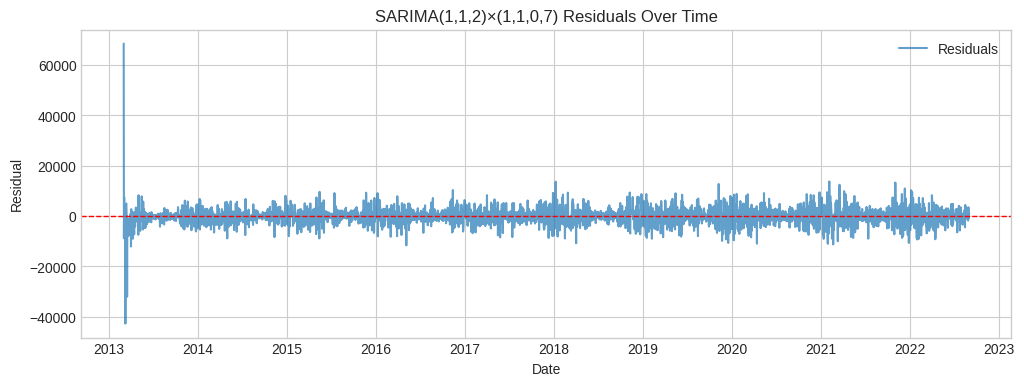

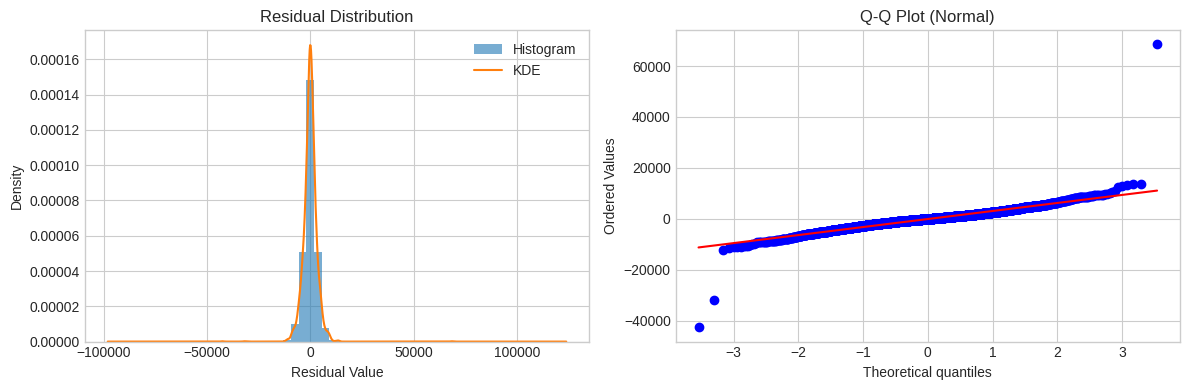

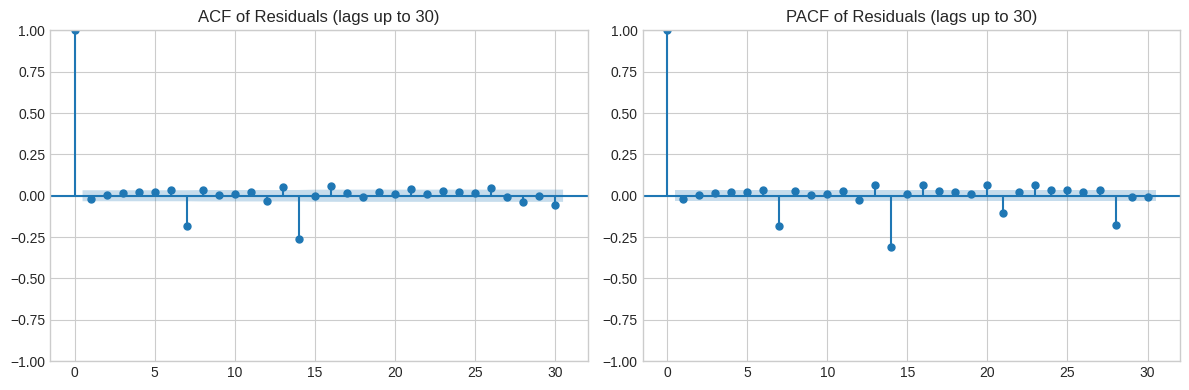


[Residuals] Distribution statistics:
  Mean: -93.986389
  Std: 3389.112213
  Min: -42671.23
  Max: 68453.00


In [31]:
# 5. Residual diagnostics

if len(results_df_s3) > 0:
    residuals_s3 = best_results_s3.resid
    
    # 5.1 Residual time series plot
    plt.figure(figsize=(12, 4))
    plt.plot(residuals_s3, label="Residuals", alpha=0.7)
    plt.axhline(y=0, color="r", linestyle="--", linewidth=1)
    plt.title(f"SARIMA({best_p},1,{best_q})×({best_P},{best_D},{best_Q},7) Residuals Over Time")
    plt.xlabel("Date")
    plt.ylabel("Residual")
    plt.legend()
    plt.show()
    
    # 5.2 Residual distribution (histogram + KDE + Q-Q)
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram with KDE
    axes[0].hist(residuals_s3, bins=30, density=True, alpha=0.6, label="Histogram")
    residuals_s3.plot(kind="kde", ax=axes[0], label="KDE")
    axes[0].set_title("Residual Distribution")
    axes[0].set_xlabel("Residual Value")
    axes[0].legend()
    
    # Q-Q plot
    stats.probplot(residuals_s3, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot (Normal)")
    
    plt.tight_layout()
    plt.show()
    
    # 5.3 ACF and PACF of residuals
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(residuals_s3, lags=30, ax=axes[0])
    plot_pacf(residuals_s3, lags=30, ax=axes[1], method="ywm")
    axes[0].set_title("ACF of Residuals (lags up to 30)")
    axes[1].set_title("PACF of Residuals (lags up to 30)")
    plt.tight_layout()
    plt.show()
    
    print("\n[Residuals] Distribution statistics:")
    print(f"  Mean: {residuals_s3.mean():.6f}")
    print(f"  Std: {residuals_s3.std():.6f}")
    print(f"  Min: {residuals_s3.min():.2f}")
    print(f"  Max: {residuals_s3.max():.2f}")

In [32]:
# 5.4 Ljung-Box test for autocorrelation

if len(results_df_s3) > 0:
    lb_14_s3 = acorr_ljungbox(residuals_s3, lags=14, return_df=True)
    lb_21_s3 = acorr_ljungbox(residuals_s3, lags=21, return_df=True)
    
    print("\n[LjungBox] Lag-14 test:")
    print(lb_14_s3.to_string())
    
    print("\n[LjungBox] Lag-21 test:")
    print(lb_21_s3.to_string())
    
    # Extract p-values at lags 14 and 21
    lb_14_pval_s3 = lb_14_s3.iloc[-1]["lb_pvalue"]
    lb_21_pval_s3 = lb_21_s3.iloc[-1]["lb_pvalue"]
    
    print(f"\n[LjungBox] p-value at lag 14: {lb_14_pval_s3:.4f}")
    print(f"[LjungBox] p-value at lag 21: {lb_21_pval_s3:.4f}")
    
    # Interpretation
    lb_14_reject_s3 = lb_14_pval_s3 < 0.05
    lb_21_reject_s3 = lb_21_pval_s3 < 0.05
    
    if lb_14_reject_s3 or lb_21_reject_s3:
        print("[LjungBox] ⚠ Ljung-Box test rejects independence (p < 0.05).")
        print("[LjungBox] → Residuals show significant autocorrelation.")
    else:
        print("[LjungBox] ✓ Ljung-Box test fails to reject independence (p > 0.05).")
        print("[LjungBox] → Residuals are approximately white noise.")


[LjungBox] Lag-14 test:
       lb_stat     lb_pvalue
1     1.622627  2.027258e-01
2     1.785499  4.095282e-01
3     2.700659  4.401153e-01
4     4.735890  3.154856e-01
5     6.386876  2.703726e-01
6    10.474632  1.060352e-01
7   130.137726  5.882408e-25
8   134.668227  3.042350e-25
9   134.709292  1.272639e-24
10  134.910368  4.640521e-24
11  136.513416  8.326067e-24
12  140.136152  5.622077e-24
13  149.562706  2.524697e-25
14  386.375487  9.371357e-74

[LjungBox] Lag-21 test:
       lb_stat     lb_pvalue
1     1.622627  2.027258e-01
2     1.785499  4.095282e-01
3     2.700659  4.401153e-01
4     4.735890  3.154856e-01
5     6.386876  2.703726e-01
6    10.474632  1.060352e-01
7   130.137726  5.882408e-25
8   134.668227  3.042350e-25
9   134.709292  1.272639e-24
10  134.910368  4.640521e-24
11  136.513416  8.326067e-24
12  140.136152  5.622077e-24
13  149.562706  2.524697e-25
14  386.375487  9.371357e-74
15  386.411426  4.938604e-73
16  398.076237  9.213699e-75
17  398.738951  3.4021

In [33]:
# 5.5 Check for seasonal autocorrelation (at lags 7, 14, 21)

if len(results_df_s3) > 0:
    # Extract ACF correlations manually to check seasonal lags
    from statsmodels.graphics.tsaplots import acf as acf_func
    
    acf_vals_s3 = acf_func(residuals_s3, nlags=30)
    lag_7_acf_s3 = acf_vals_s3[7]
    lag_14_acf_s3 = acf_vals_s3[14]
    lag_21_acf_s3 = acf_vals_s3[21]
    
    # Rough 95% CI for ACF: ±1.96/sqrt(n)
    n_s3 = len(residuals_s3)
    ci_upper_s3 = 1.96 / np.sqrt(n_s3)
    ci_lower_s3 = -1.96 / np.sqrt(n_s3)
    
    print(f"\n[Seasonality] Residual ACF at seasonal lags:")
    print(f"  Lag 7 ACF: {lag_7_acf_s3:.4f} (95% CI: [{ci_lower_s3:.4f}, {ci_upper_s3:.4f}])")
    print(f"  Lag 14 ACF: {lag_14_acf_s3:.4f}")
    print(f"  Lag 21 ACF: {lag_21_acf_s3:.4f}")
    
    # Check if any lag-7 multiple exceeds confidence interval
    lag_7_outside_ci_s3 = abs(lag_7_acf_s3) > ci_upper_s3
    lag_14_outside_ci_s3 = abs(lag_14_acf_s3) > ci_upper_s3
    lag_21_outside_ci_s3 = abs(lag_21_acf_s3) > ci_upper_s3
    
    if lag_7_outside_ci_s3 or lag_14_outside_ci_s3 or lag_21_outside_ci_s3:
        print("[Seasonality] ⚠ Autocorrelation still present at seasonal lags.")
        print("[Seasonality] → Seasonal structure not fully captured.")
    else:
        print("[Seasonality] ✓ No strong autocorrelation at seasonal lags.")
        print("[Seasonality] → Seasonal structure successfully removed.")


[Seasonality] Residual ACF at seasonal lags:
  Lag 7 ACF: -0.1854 (95% CI: [-0.0333, 0.0333])
  Lag 14 ACF: -0.2606
  Lag 21 ACF: 0.0396
[Seasonality] ⚠ Autocorrelation still present at seasonal lags.
[Seasonality] → Seasonal structure not fully captured.


In [34]:
# 6. Structured conclusion block

if len(results_df_s3) > 0:
    # Determine if residuals are approximately white noise
    residuals_white_noise_s3 = (not lb_14_reject_s3) and (not lb_21_reject_s3)
    
    # Determine if seasonal autocorrelation has been removed
    seasonal_removed_s3 = not (lag_7_outside_ci_s3 or lag_14_outside_ci_s3 or lag_21_outside_ci_s3)
    
    # Overall model adequacy: white noise residuals with no seasonal structure
    model_adequate_s3 = residuals_white_noise_s3 and seasonal_removed_s3
    
    print("\n" + "=" * 60)
    print("SARIMA MODEL SUMMARY")
    print("=" * 60)
    print(f"Selected order: ({best_p},1,{best_q}) × ({best_P},{best_D},{best_Q},7)")
    print(f"AIC: {best_row_s3['AIC']:.2f}")
    print(f"BIC: {best_row_s3['BIC']:.2f}")
    print(f"\nResiduals approximately white noise? {'Yes' if residuals_white_noise_s3 else 'No'}")
    print(f"  → Ljung-Box lag-14 p-value: {lb_14_pval_s3:.4f}")
    print(f"  → Ljung-Box lag-21 p-value: {lb_21_pval_s3:.4f}")
    print(f"\nSeasonal autocorrelation removed? {'Yes' if seasonal_removed_s3 else 'No'}")
    print(f"  → Lag-7 ACF: {lag_7_acf_s3:.4f} (outside {ci_upper_s3:.4f} CI: {lag_7_outside_ci_s3})")
    print(f"  → Lag-14 ACF: {lag_14_acf_s3:.4f} (outside {ci_upper_s3:.4f} CI: {lag_14_outside_ci_s3})")
    print(f"  → Lag-21 ACF: {lag_21_acf_s3:.4f} (outside {ci_upper_s3:.4f} CI: {lag_21_outside_ci_s3})")
    print(f"\nIs model adequate? {'Yes' if model_adequate_s3 else 'No'}")
    print("=" * 60)
    
    # Interpretation
    if model_adequate_s3:
        print("\n[Interpretation] SARIMA baseline shows residuals as white noise with")
        print("no seasonal autocorrelation. Model adequacy achieved for in-sample fit.")
    elif residuals_white_noise_s3 and not seasonal_removed_s3:
        print("\n[Interpretation] Residuals are white noise but seasonal structure")
        print("remains. Consider increasing P or Q or revisiting seasonal structure.")
    elif seasonal_removed_s3 and not residuals_white_noise_s3:
        print("\n[Interpretation] Seasonal structure removed but residuals show")
        print("autocorrelation. Consider increasing p or q for non-seasonal components.")
    else:
        print("\n[Interpretation] Both autocorrelation and seasonal structure remain.")
        print("Model requires further refinement.")
else:
    print("[Conclusion] ✗ No converged models available for conclusion.")


SARIMA MODEL SUMMARY
Selected order: (1,1,2) × (1,1,0,7)
AIC: 65505.52
BIC: 65536.27

Residuals approximately white noise? No
  → Ljung-Box lag-14 p-value: 0.0000
  → Ljung-Box lag-21 p-value: 0.0000

Seasonal autocorrelation removed? No
  → Lag-7 ACF: -0.1854 (outside 0.0333 CI: True)
  → Lag-14 ACF: -0.2606 (outside 0.0333 CI: True)
  → Lag-21 ACF: 0.0396 (outside 0.0333 CI: True)

Is model adequate? No

[Interpretation] Both autocorrelation and seasonal structure remain.
Model requires further refinement.


# Step 4: SARIMAX Rolling Forecast with Test Data

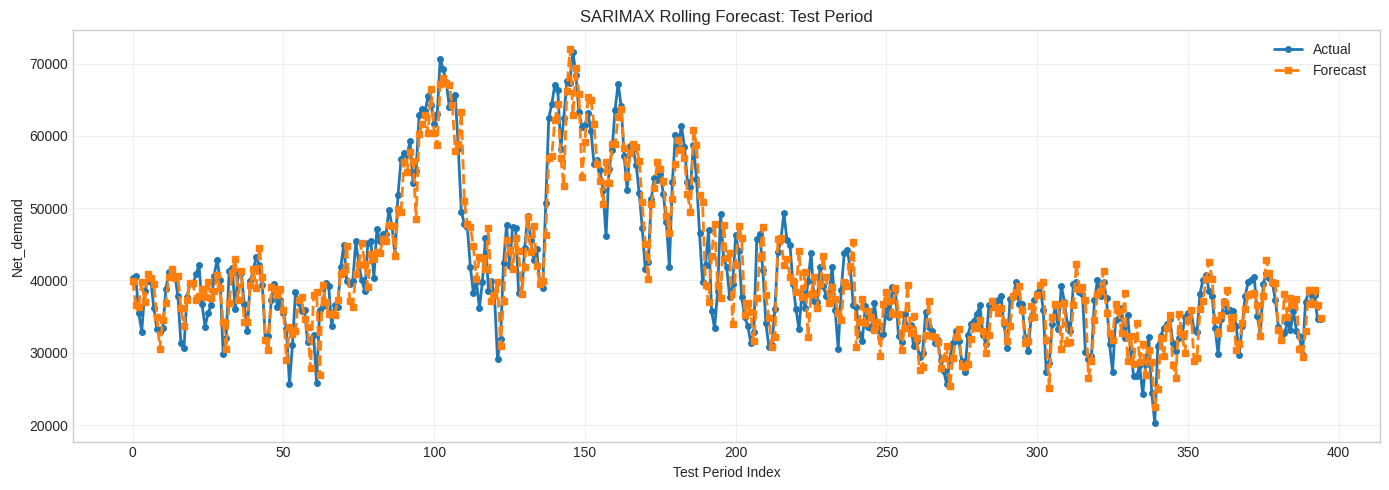

In [ ]:
# Load train and test data
train_df_s4 = pd.read_csv("../Data/train.csv", parse_dates=["Date"])
test_df_s4 = pd.read_csv("../Data/test.csv", parse_dates=["Date"])

train_df_s4 = train_df_s4.sort_values("Date").reset_index(drop=True)
test_df_s4 = test_df_s4.sort_values("Date").reset_index(drop=True)

# Prepare data
y_train_s4 = train_df_s4["Net_demand"].values
exog_cols = ["Temp", "Holiday", "toy"]
X_train_s4 = train_df_s4[exog_cols].values
X_test_s4 = test_df_s4[exog_cols].values
y_true_s4 = test_df_s4["Net_demand.1"].values

# Fit SARIMAX on training data
model_s4 = SARIMAX(
    y_train_s4,
    exog=X_train_s4,
    order=(1, 1, 2),
    seasonal_order=(1, 1, 1, 7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results_s4 = model_s4.fit(disp=False)

# Rolling forecast with incremental updates
forecasts_s4 = []
results_roll = results_s4

for i in range(len(test_df_s4)):
    # Forecast one step ahead
    forecast = results_roll.get_forecast(steps=1, exog=X_test_s4[[i]])
    forecasts_s4.append(forecast.predicted_mean[0])
    
    # Extend model with observation (incremental learning)
    results_roll = results_roll.extend(
        endog=[y_true_s4[i]],
        exog=X_test_s4[[i]]
    )


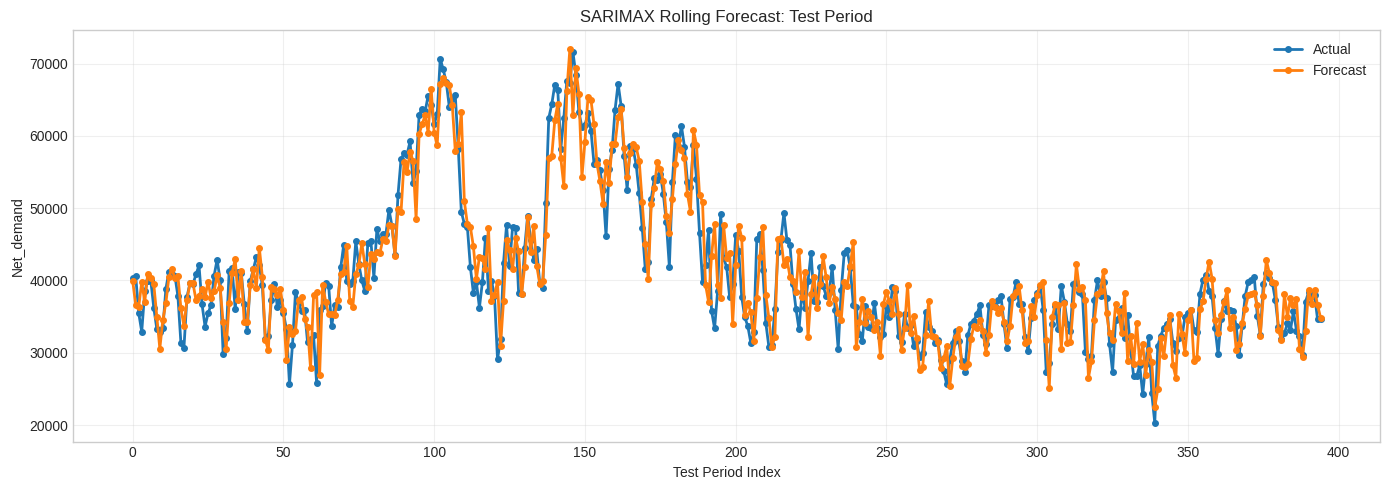

In [42]:

# Plot result
plt.figure(figsize=(14, 5))
plt.plot(range(len(y_true_s4)), y_true_s4, "o-", label="Actual", linewidth=2, markersize=4)
plt.plot(range(len(forecasts_s4)), forecasts_s4, "o-", label="Forecast", linewidth=2, markersize=4)
plt.xlabel("Test Period Index")
plt.ylabel("Net_demand")
plt.title("SARIMAX Rolling Forecast: Test Period")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [41]:
forecasts_s4

[np.float64(39970.288603468216),
 np.float64(36586.985674986936),
 np.float64(36347.65507840109),
 np.float64(39813.263353282295),
 np.float64(37023.22750056666),
 np.float64(40947.00479486893),
 np.float64(40293.44081266993),
 np.float64(39469.06716261915),
 np.float64(34968.21700584938),
 np.float64(30580.230426708207),
 np.float64(34540.897632209584),
 np.float64(36862.73680879874),
 np.float64(40419.98720096462),
 np.float64(41643.98650002919),
 np.float64(40274.38252609069),
 np.float64(40601.9933161677),
 np.float64(36166.58540182983),
 np.float64(33693.1454427453),
 np.float64(37337.369429370214),
 np.float64(39611.71307052681),
 np.float64(39599.56547396607),
 np.float64(37284.604605275905),
 np.float64(37914.46105147785),
 np.float64(38823.725514034886),
 np.float64(37674.30670429111),
 np.float64(39839.46868913868),
 np.float64(37536.61530696647),
 np.float64(38487.39875044723),
 np.float64(40736.458918334305),
 np.float64(38990.97769130717),
 np.float64(34224.54942810163),
 

In [49]:
# Create DataFrame and save to CSV
forecast_df = pd.DataFrame({
    'Id': range(1, len(forecasts_s4) + 1),
    'Net_demand': forecasts_s4
})

# Save to CSV
output_path = "sarimax_forecasts.csv"
forecast_df.to_csv(output_path, index=False)

print(f"Forecasts saved to {output_path}")
print(f"\nFirst few rows:")
print(forecast_df.head())

Forecasts saved to sarimax_forecasts.csv

First few rows:
   Id    Net_demand
0   1  39970.288603
1   2  36586.985675
2   3  36347.655078
3   4  39813.263353
4   5  37023.227501


In [47]:
forecast_df

,Id,Net_demand
0,0,39970.288603
1,1,36586.985675
2,2,36347.655078
3,3,39813.263353
4,4,37023.227501
...,...,...
390,390,38622.517698
391,391,36800.646701
392,392,38665.326292
393,393,36592.873320


In [48]:
test_df_s4["Net_demand.1"]

0      40309.562500
1      40596.979167
2      35496.333333
3      32913.187500
4      38491.208333
           ...     
390    38360.770833
391    37836.500000
392    37951.000000
393    34614.125000
394    34625.437500
Name: Net_demand.1, Length: 395, dtype: float64